# 16. Introduction to Raster Data

This is a very brief introduction to reading raster data and basic manipulations in Python. We'll walk through one of the most commonly used raster python packages, `rasterio`. We'll be using the [National Land Cover Database (NLCD)](https://www.mrlc.gov/data/legends/national-land-cover-database-2016-nlcd2016-legend) from 2011 that was downloaded from [here](https://viewer.nationalmap.gov/basic).

<img src="https://www.mdpi.com/remotesensing/remotesensing-11-02971/article_deploy/html/images/remotesensing-11-02971-g004.png" width="600">

> Note: They also have a [cool online viewer](https://www.mrlc.gov/viewer/) that is free and open access.

In [45]:
import pandas as pd
import geopandas as gpd

import matplotlib # base python plotting library
import matplotlib.pyplot as plt # submodule of matplotlib
from matplotlib.patches import Patch

import json
import numpy as np

# To display plots, maps, charts etc in the notebook
%matplotlib inline  

To use raster data we'll be using the `rasterio` package, which is a popular package that helps you read, write, and manipulate raster data. 

In [4]:
import rasterio
from rasterio.plot import show, plotting_extent
from rasterio.mask import mask

## 16.1 Import data and plot

To open our NLCD subset data, we'll use the `rasterio.open` function

In [6]:
nlcd_2011 = rasterio.open('notebook_data/raster/nlcd2011_sf.tif')

Let's check out what we get.

In [7]:
nlcd_2011

<open DatasetReader name='notebook_data/raster/nlcd2011_sf.tif' mode='r'>

Let's dissect this output here. We can look at the helper documentation for clues.

In [8]:
?rasterio.open

Which reads that the function returns a ``DatasetReader`` or ``DatasetWriter`` object. Unlike in `GeoPandas` which we've been utilizing a lot of, we don't have a directly editable object here. However, `rasterio` does have functions in place where we can still use this returned object directly.

For example, we can easily plot our NLCD data using `rasterio.plot.show`.

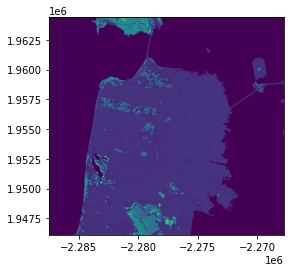

<AxesSubplot:>

In [9]:
rasterio.plot.show(nlcd_2011)

And just like how we formatted our `matplotlib` plots when we were using GeoDataFrames, we can still do that with this raster plotting function.

In [18]:
?rasterio.plot.show

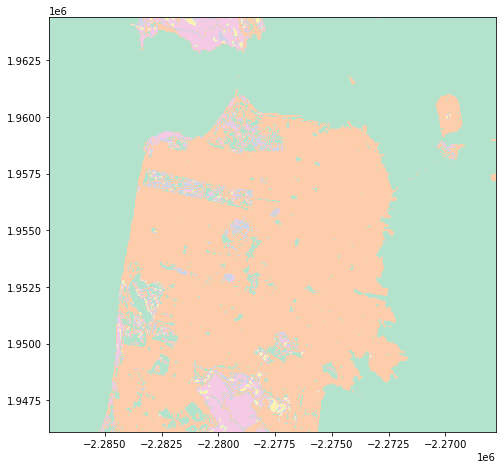

In [20]:
fig, ax = plt.subplots(figsize=(8,8))
plt_nlcd = rasterio.plot.show(nlcd_2011, cmap='Pastel2', ax=ax)

(Take note of what you think could be improved here... we'll come back to this)

We can also plot a histogram of our data in a very similar way.

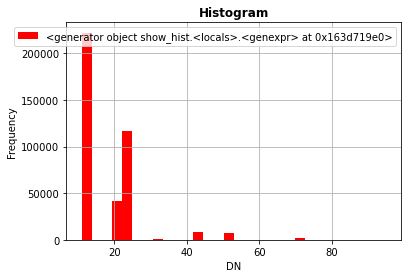

In [16]:
rasterio.plot.show_hist(nlcd_2011, bins=30)

We can see that we have more values on the lower end than on the higher end. To really understand the values that we see here let's [take a look at the legend](https://www.mrlc.gov/data/legends/national-land-cover-database-2016-nlcd2016-legend).

<img src ="assets/images/NLCD_Colour_Classification_Update.jpg" width="200" align="center">

## 16.2 Raster data structure

> *Note:* If you need a refresher on what raster data is and relevant terminology. Check out the first lesson that covers geospatial topics

Now that we have a basic grasp on how to pull in and plot raster data, we can dig a little deeper to see what information we have.

First let's check the number of bands there are in our dataset.

In [21]:
nlcd_2011.count

1

In this case we only have 1 band. If you're pulling in aerial image, you might have 3 bands (red, green, blue). In the case you're bringing in remote sensing data like Landsat or MODIS you might have more!

Not let's check out what meta data we have.

In [22]:
nlcd_2011.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 656,
 'height': 609,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["Albers_Conical_Equal_Area",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(30.0, 0.0, -2287455.0,
        0.0, -30.0, 1964385.0)}

So we have a lot of good information here. Let's unpack it:

- `driver`: the file type (simialr to what we see in `open` and Geopandas `open`)
- `dtype`: the data type of each of your pixels
- `nodata`: the value that is set for no data pixels
- `width`: the number of pixels wide your dataset is
- `height`: the number of pixels high your dataset is
- `count`: the number of bands in your dataset
- `crs`: the coordiante reference system (CRS) of your data
- `transform`: the affine transform matrix that tell us which pixel locations in each row and column align with spatial locations (longitude, latitude).

We can also get similar information by calling `profile`.

In [24]:
nlcd_2011.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 656, 'height': 609, 'count': 1, 'crs': CRS.from_wkt('PROJCS["Albers_Conical_Equal_Area",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, -2287455.0,
       0.0, -30.0, 1964385.0), 'tiled': False, 'interleave': 'band'}

In [101]:
nlcd_2011.crs

CRS.from_wkt('PROJCS["Albers_Conical_Equal_Area",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

Okay, but now we want to actually access our data. We can read in our data as a Numpy ndarray.

In [25]:
nlcd_2011_array = nlcd_2011.read()
nlcd_2011_array

array([[[11, 11, 11, ..., 11, 11, 11],
        [11, 11, 11, ..., 11, 11, 11],
        [11, 11, 11, ..., 11, 11, 11],
        ...,
        [11, 11, 11, ..., 11, 11, 11],
        [11, 11, 11, ..., 11, 11, 11],
        [11, 11, 11, ..., 11, 11, 11]]], dtype=uint8)

And we can call shape and see we have a 3D array.

In [27]:
nlcd_2011_array.shape

(1, 609, 656)

Much like other Numpy arrays, we can look at the min, mean, and max of our data

In [28]:
print("Minimum: ", np.nanmin(nlcd_2011_array))
print("Max: ", np.nanmean(nlcd_2011_array))
print("Mean: ", np.nanmax(nlcd_2011_array))

Minimum:  11
Max:  17.570234590892706
Mean:  95


And since we have our data in an array form now, we can plot it using not a `rasterio` function, but simply `plt.imshow`.

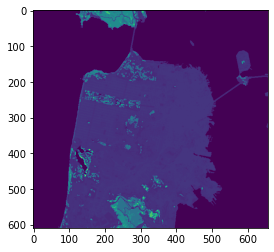

In [32]:
plt.imshow(nlcd_2011_array[0,:,:])

Notice that we specified this plotting by making our array 2D. This gives us more flexibility about how we want to create our plots. You can do something like this:

In [46]:
# Define the colors you want
cmap = matplotlib.colors.ListedColormap(['royalblue', #11
                                        'white', #12
                                        'beige', #21
                                        'salmon', #22
                                        'red', #23
                                        'darkred', #24
                                        'grey', #31
                                        'yellowgreen', #41
                                        'darkgreen', #42
                                        'lightgreen', # 43
                                        'darkgoldenrod', #51
                                        'tan', # 52
                                        'wheat', # 71
                                        'darkkhaki', #72
                                        'darkseagreen', #73
                                         'mediumseagreen', #74
                                         'gold', #81
                                         'chocolate', #82
                                         'lightsteelblue', #90
                                         'steelblue', #95
                                        ])
cmap.set_under('#FFFFFF')
cmap.set_over('#FFFFFF')
# Define a normalization from values -> colors
norm = matplotlib.colors.BoundaryNorm([10.5,
                                       11.5,
                                       12.5,
                                       21.5,
                                       22.5,
                                       23.5,
                                       24.5,
                                       31.5,
                                       41.5, 
                                       42.5,
                                       43.5,
                                       51.5,
                                       52.5,
                                       71.5,
                                       72.5,
                                       73.5,
                                       74.5,
                                       81.5,
                                       82.5,
                                       90.5,
                                       95.5,
                                      ],20)


legend_labels = { 'royalblue':'Open Water', 
                  'white':'Perennial Ice/Snow',
                  'beige':'Developed, Open Space',
                  'salmon':'Developed, Low Intensity',
                  'red':'Developed, Medium Intensity',
                  'darkred':'Developed High Intensity',
                  'grey':'Barren Land (Rock/Sand/Clay)',
                  'yellowgreen':'Deciduous Forest',
                  'darkgreen':'Evergreen Forest',
                  'lightgreen':'Mixed Forest',
                  'darkgoldenrod':'Dwarf Scrub',
                  'tan':'Shrub/Scrub',
                  'wheat':'Grassland/Herbaceous',
                  'darkkhaki':'Sedge/Herbaceous',
                  'darkseagreen':'Lichens',
                  'mediumseagreen':'Moss',
                  'gold':'Pasture/Hay',
                  'chocolate':'Cultivated Crops',
                  'lightsteelblue':'Woody Wetlands',
                  'steelblue':'Emergent Herbaceous Wetlands'}

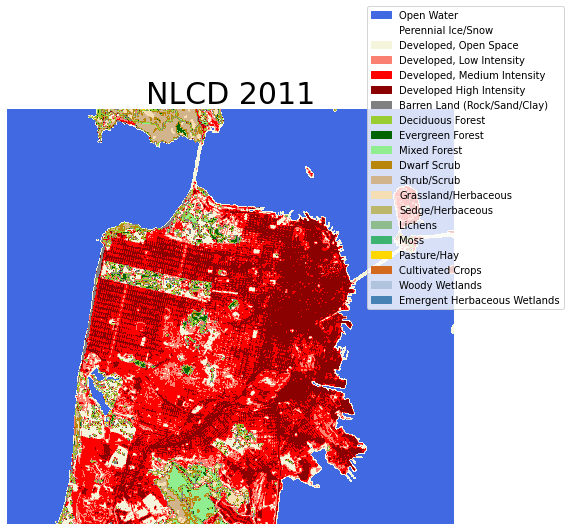

In [54]:
fig, ax = plt.subplots(figsize=(8, 8))
plt_nlcd = ax.imshow(nlcd_2011_array[0,:,:], cmap=cmap, norm=norm)
ax.set_title('NLCD 2011', fontsize=30)

# Remove axes
ax.set_frame_on(False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xticks([])
ax.set_yticks([])

# Add color bar
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

fig.legend(handles=patches, facecolor="white",bbox_to_anchor=(1.1, 1.05))




## 16.2 Mask raster data

*Masking* is a common action that is done with raster data where you "mask" everything outside of a certain geometry.

To do this let's first bring in the san francisco county data.

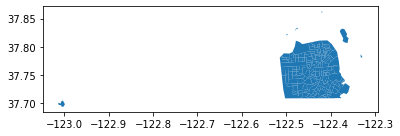

In [138]:
# Bring in census tracts
tracts_gdf = gpd.read_file("zip://notebook_data/census/Tracts/cb_2013_06_tract_500k.zip").to_crs('epsg:4326')

# Narrow it down to San Francisco County
tracts_gdf_sf = tracts_gdf[tracts_gdf['COUNTYFP']=='075']

tracts_gdf_sf.plot()
plt.show()

We forgot about the Farollon islands! Let's crop those out.

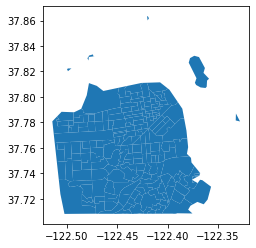

In [139]:
# Crop out Farallon
tracts_gdf_sf = tracts_gdf_sf.cx[-122.8:-122.35, 37.65:37.85].copy().reset_index(drop=True)

tracts_gdf_sf.plot()
plt.show()

We'll want to check the crs of our GeoDataFrame

In [140]:
tracts_gdf_sf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now we will call the `mask` function from `rasterio`. Let's look at the documentation first.

In [135]:
?mask

We actually recommend using the `rioxarray` method instesd. So we'll import a new package.

In [142]:
import rioxarray as rxr

Open our same NLCD data...

In [143]:
nlcd_2011 = rxr.open_rasterio('notebook_data/raster/nlcd2011_sf.tif',
                              masked=True).squeeze()

Reproject our NLCD to be in the same coordinate reference system as the san francisco data

In [150]:
test = nlcd_2011.rio.reproject(tracts_gdf_sf.crs)

And clip our data to the san francisco geometry

In [146]:
clipped = test.rio.clip(tracts_gdf_sf.geometry, tracts_gdf_sf.crs, drop=False, invert=False)

We can easily plot this using `.plot()`

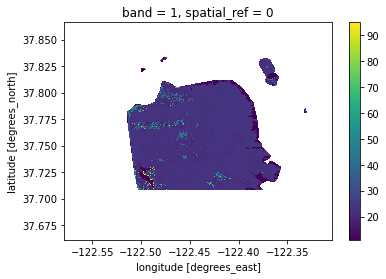

In [147]:
clipped.plot()

And we can also make a pretty map like we did before.

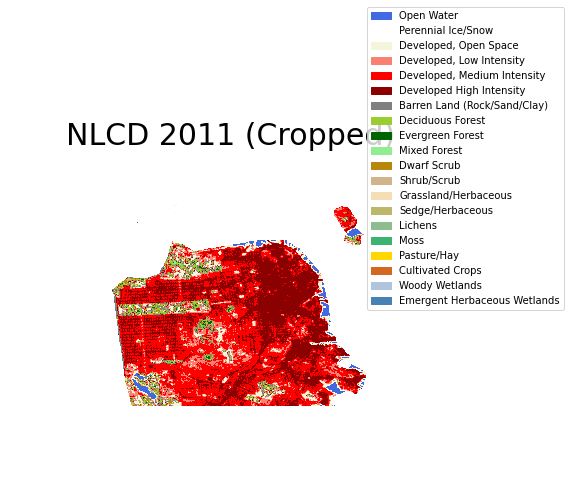

In [153]:
fig, ax = plt.subplots(figsize=(8, 8))
plt_nlcd = ax.imshow(clipped, cmap=cmap, norm=norm)
ax.set_title('NLCD 2011 (Cropped)', fontsize=30)

# Remove axes
ax.set_frame_on(False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xticks([])
ax.set_yticks([])

# Add color bar
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

fig.legend(handles=patches, facecolor="white",bbox_to_anchor=(1.1, 1.05))



## 16.3 Other resources
We really only grazed the surface here. We've linked a couple of resources that dive into raster data.

- [EarthLab](https://www.earthdatascience.org)
- [Software Carpentry](https://carpentries-incubator.github.io/geospatial-python/aio/index.html)
- [Intro to Python GIS](https://automating-gis-processes.github.io/CSC/index.html)

---
<div style="display:inline-block;vertical-align:middle;">
<a href="https://dlab.berkeley.edu/" target="_blank"><img src ="assets/images/dlab_logo.png" width="75" align="left">
</a>
</div>

<div style="display:inline-block;vertical-align:middle;">
    <div style="font-size:larger">&nbsp;D-Lab @ University of California - Berkeley</div>
    <div>&nbsp;Team Geo<div>
</div>
        

